1. What is the current distribution of landlords and housing listed in current affordable housing programs?

2. What is the geographic distribution of these landlords by city council district?


In [299]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')
#import seaborn as sns; sns.set()

from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
import math

#this will mute errors that make your final pdf less legible
import warnings
warnings.filterwarnings('ignore')

In [300]:
df = pd.read_csv('msamd_14454.csv')
df2 = pd.read_csv('income-restricted-inventory-2021.csv')

df3 = pd.read_excel('TRACT_ZIP_122021.xlsx')

df.head()

,activity_year,lei,derived_msa-md,state_code,county_code,census_tract,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category,derived_ethnicity,...,denial_reason-2,denial_reason-3,denial_reason-4,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units
0,2021,549300DAUXQ2DCY4H838,14454,MA,25021.0,2.502140e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,4448,31.27,113700,91,1016,1519,72
1,2021,549300DAUXQ2DCY4H838,14454,MA,25021.0,2.502140e+10,NC,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,4230,7.78,113700,179,1228,1394,60
2,2021,549300DAUXQ2DCY4H838,14454,MA,25023.0,2.502350e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,7312,2.95,113700,132,2099,2345,43
3,2021,549300DAUXQ2DCY4H838,14454,MA,25023.0,2.502351e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,2380,77.98,113700,18,16,343,51
4,2021,549300DAUXQ2DCY4H838,14454,MA,25025.0,2.502513e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Ethnicity Not Available,...,NaN,NaN,NaN,5399,69.98,113700,54,568,1437,48


In [301]:
print(df.shape)
#some (not all) data cleaning
#getting all rows where loans where home_loans
home_loans = df.loc[(df['loan_purpose'] == 1)]
# home_loans[['income', 'tract_to_msa_income_percentage', 'ffiec_msa_md_median_family_income', 'census_tract']]

# df.groupby(by=['county_code'])['lei'].count()
# df.groupby(by=['derived_race']).count()


#no NaNs
home_loans_2 = home_loans.dropna(subset=['census_tract'])

print(home_loans.shape)
print(home_loans_2.shape)

(165342, 99)
(42655, 99)
(42632, 99)


In [308]:
def tract_to_zip(tract_num):
    rows = df3.loc[df3['tract'] == tract_num]
    idx = rows['tot_ratio'].idxmax()
    zipcode = df3.loc[idx]['zip']
    
    return zipcode

# x = df3.loc[df3['tract'] == test]
# x['tot_ratio'].idxmax()

# print(df3.loc[71456]['zip'])

# print(tract_to_zip(test))
# print(home_loans_2.shape)


#adding zipcode column

home_loans_2['census_tract']

temp = [tract_to_zip(tract_num) for tract_num in home_loans_2['census_tract']]

home_loans_2['zipcodes'] = temp

home_loans_2['zipcodes']




0         2026
3         2301
4         2132
8         2038
9         2061
          ... 
165329    2130
165330    2081
165331    2119
165332    2081
165340    2170
Name: zipcodes, Length: 42632, dtype: int64

<Axes: xlabel='zipcodes'>

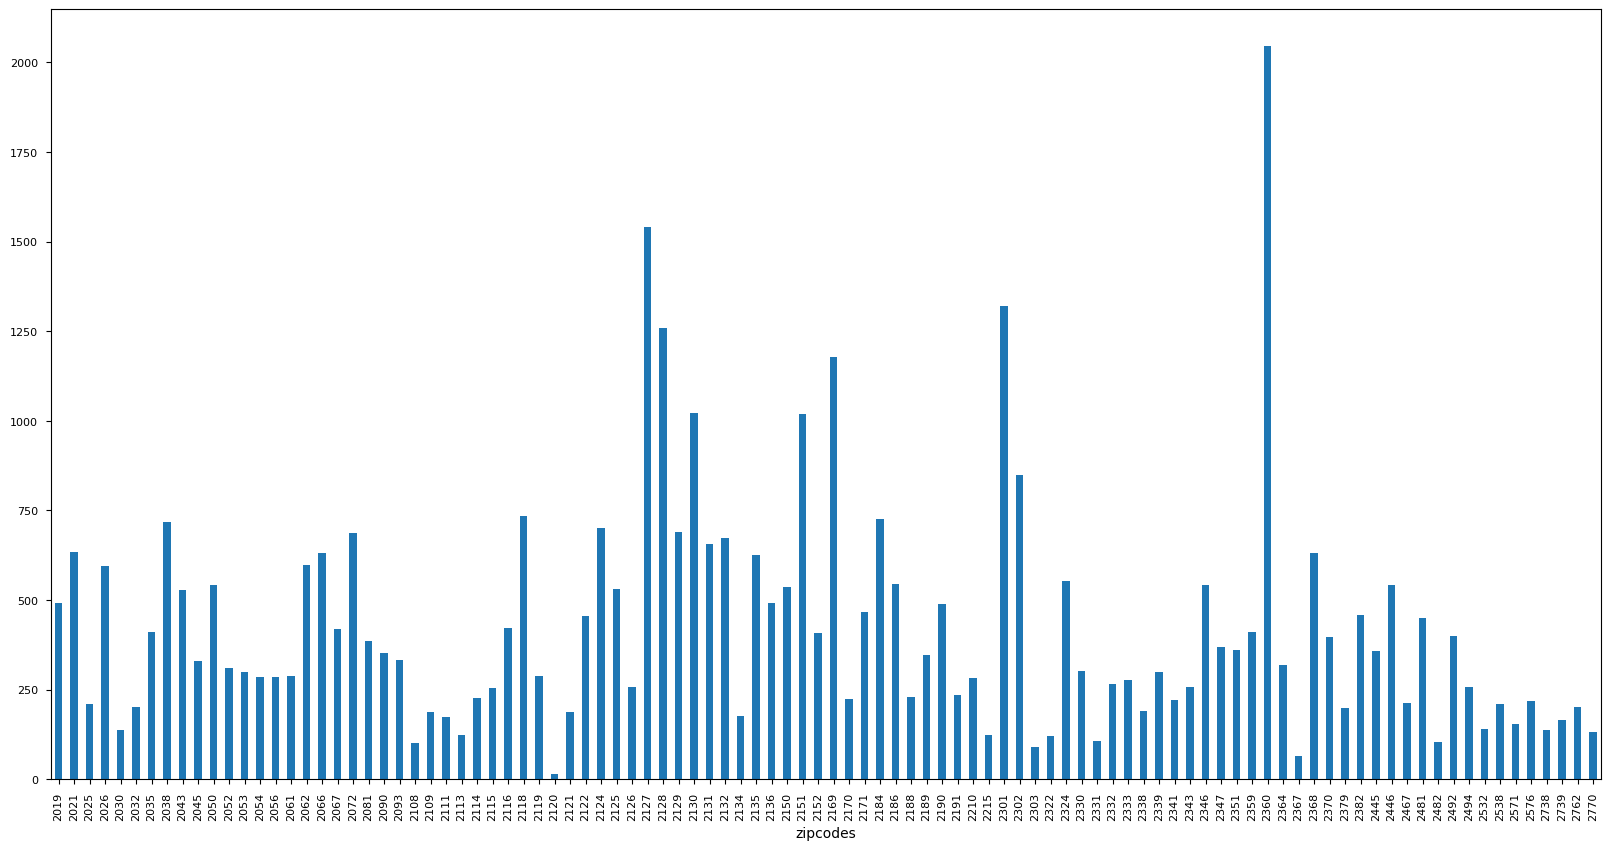

In [277]:
#grouping by zips and bar graph of zips

zips = home_loans_2.groupby(by=['zipcodes'])['zipcodes'].count()

zips.plot(kind="bar", figsize=(20,10))


In [338]:
#sorting zips into districts


district_1 = [1267, 1237, 1201, 1254, 1266, 1230, 1258, 1257, 1247, 1220, 
              1225, 1226, 1240, 1238, 1350, 1256, 1270, 1235, 1223, 1253,
              1259, 1245, 1367, 1339, 1070, 1026, 1098, 1243, 1011, 1029,
              1255, 1346, 1340, 1337, 1370, 1330, 1341, 1032, 1096, 1027, 
              1050, 1073, 1085, 1077, 1071, 1008, 1034, 1040, 1089, 1075, 
              1033, 1020, 1109, 1106, 1028, 1036, 1057, 1069, 1010, 1506,
              1566, 1081, 1521, 1550, 1507, 1571, 
             ]

district_2 = [1301, 1342, 1373, 1062, 1354, 1351, 1375, 1035, 1360, 1344, 
              1379, 1054, 1002, 1378, 1344, 1379, 1054, 1072, 1364, 1355, 
              1007, 1062, 1368, 1331, 1366, 1037, 1082, 1436, 1468, 1005, 
              1531, 1585, 1452, 1068, 1535, 1543, 1541, 1522, 1520, 1612,
              1524, 1453, 1564, 1583, 1505, 1501, 1540, 1570, 1545, 1604,
              1527, 1590, 1516, 1519, 1569, 1532, 1581, 1568, 1756, 1504
             ]

district_3 = [1475, 1440, 1473, 1430, 1431, 1420, 1474, 1462, 1463, 1464,
              1453, 1523, 1510, 1450, 1432, 1434, 1451, 1827, 1886, 1460, 
              1719, 1775, 1749, 1752, 1754, 1720, 1879, 1863, 1824, 1741, 
              1742, 1854, 1852, 1826, 1810, 1844, 1841, 1832, 1835, 1830
            ]

district_4 = [2472, 2135, 2130, 2492, 2030, 2052, 1748, 1757, 2053, 2054,
              2019, 2038, 2056, 2093, 2035, 2067, 2762, 2048, 2356, 2760, 
              2703, 2766, 2780, 2769, 2764, 2715, 2779, 2718, 2347, 2702,
              2777, 2720, 2702, 2717, 2347, 2494, 2446, 2467, 2445
            ]

district_5 = [1772, 1721, 1746, 1770, 1702, 1701, 1776, 1778, 1760, 2493,
              1773, 2451, 2453, 2452, 2421, 2420, 2478, 2472, 2474, 1890,
              1801, 2180, 2155, 2176, 2148, 2151, 2152, 2128, 2481, 2482
            ]

district_6 = [1860, 1913, 1952, 1985, 1950, 1922, 1951, 1834, 1833, 1969, 
              1938, 1921, 1845, 1966, 1930, 1929, 1982, 1983, 1944, 1915, 
              1984, 1949, 1923, 1864, 1887, 1976, 1862, 1821, 1803, 1730, 
              1880, 1906, 1902, 1907, 1945, 1970, 1960, 1960, 1940
            ]

district_7 = [2155, 2145, 2149, 2184, 2150, 2128, 2118, 2119, 2121, 2121, 
              2135, 2139, 2129, 2155, 2124, 2126, 2136, 2186, 2368, 2215,
              2131, 2115, 2134, 2111, 2120
            ]

district_8 = [2130, 2026, 2090, 2062, 2081, 2021, 2072, 2322, 2301, 2379, 
              2324, 2333, 2382, 2302, 2343, 2190, 2184, 2186, 2124, 2169, 
              2043, 2191, 2045, 2043, 2025, 2066, 2050, 2047, 2132, 2170,
              2032, 2303, 2171, 2127, 2122, 2351, 2188, 2125, 2109, 2189,
              2113, 2108, 2210, 2116, 2114
            ]

district_9 = [2061, 2339, 2050, 2332, 2359, 2338, 2364, 2324, 2367, 2346,
              2330, 2360, 2364, 2330, 2571, 2770, 2720, 2790, 2748, 2740, 
              2738, 2562, 2563, 2542, 2536, 2668, 2675, 2660, 2631, 2645,
              2631, 2667, 2652, 2657, 2641, 2713, 2543, 2535, 2539, 2575,
              2557, 2554, 2370, 2532, 2739, 2331, 2341, 2538, 2576
            ]



def find_district(zipcode):
    if zipcode in district_1:
        return 1
    elif zipcode in district_2:
        return 2
    elif zipcode in district_3:
        return 3
    elif zipcode in district_4:
        return 4
    elif zipcode in district_5:
        return 5
    elif zipcode in district_6:
        return 6
    elif zipcode in district_7:
        return 7
    elif zipcode in district_8:
        return 8
    elif zipcode in district_9:
        return 9
    else:
        return zipcode
    
    

home_loans_2['districts'] = home_loans_2['zipcodes'].apply(lambda x: find_district(x))

# df['C'] = df['A'].apply(lambda x: square(x))

    
# home_loans_2['']

# home_loans_2['districts'].unique()


array([8, 4, 9, 7, 5])

<Axes: xlabel='districts'>

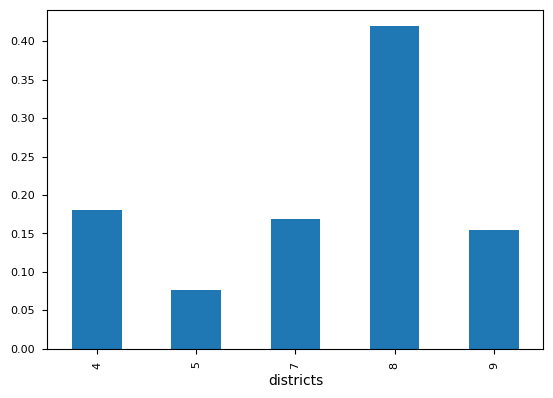

In [343]:
#plotting the 

total = home_loans_2['districts'].count()

districts = home_loans_2.groupby(by=['districts'])['districts'].count() / total

districts.plot(kind="bar")
